In [172]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import shap

In [173]:
warnings.filterwarnings('ignore')

In [174]:
train_df_final = pd.read_csv('./input/processed/train_df_final_v5.csv')
test_df_final = pd.read_csv('./input/processed/test_df_final_v5.csv')

In [175]:
train_df_final.head()

,id,climatology_temp,target,elev,doy_sin,doy_cos,day_length,dew_point_avg,humidity_avg,dew_humidity_interaction,...,humidity_avg_x_dew_depression_morning,humidity_avg_x_dew_depression_morning_sq,dew_change_day_X_humidity_avg,humidity_avg_x_dew_depression_night,temp_evening_minus_night_avg,STA_slp_X_TEMNA,STA_slp_X_elev,ratio_slp_avg_div_pressure_tendency,surface_temp_anomaly_lag1,surface_temp_anomaly_roll3
0,0,-2.707143,-3.992857,115.62,0.017213,0.999852,9.426812,-16.808333,46.875000,-787.890625,...,425.000000,180625.000000,268.750000,453.125000,3.000000,-8925.502143,-343988.852586,-544.427918,0.000000,-2.876190
1,1,-3.646429,-1.653571,115.62,0.034422,0.999407,9.437325,-17.466667,45.500000,-794.733333,...,371.583333,138074.173611,525.525000,364.000000,2.966667,-6498.286659,-253257.945013,941.037023,-2.876190,-2.116071
2,2,-2.694643,-0.005357,115.62,0.051620,0.998667,9.448699,-17.645833,43.583333,-769.064236,...,336.318056,113109.834493,584.743056,320.337500,3.550000,-9659.030636,-314585.104840,2590.108108,-2.116071,-2.539484
3,3,-2.501786,-0.898214,115.62,0.068802,0.997630,9.460926,-11.966667,53.166667,-636.227778,...,434.194444,188524.815586,257.858333,462.550000,4.733333,-6930.308497,-169284.986295,-118.595799,-2.626190,-2.053770
4,4,-2.625000,-1.775000,115.62,0.085965,0.996298,9.473997,-15.729167,40.583333,-638.342014,...,357.809722,128027.797317,594.545833,114.986111,-0.316667,249.557347,-91117.327850,642.452723,-1.419048,-1.603968


# Dataset Splitting

In [176]:
features = [col for col in train_df_final.columns if col not in ['id', 'target']]

X = train_df_final[features].values
y = train_df_final['target'].values
X_test = test_df_final[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Optuna Setup

In [177]:
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 1000, 8000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'random_state': 52,
        'verbosity': 0
    }
    model = xgb.XGBRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False,
    )
    preds = model.predict(X_val)
    return root_mean_squared_error(y_val, preds)

In [178]:
# study = optuna.create_study(direction='minimize', study_name='xgb_reg_opt')
# study.optimize(objective, n_trials=30, n_jobs=10)
# print("Best trial:")
# print(f"  RMSE: {study.best_value:.5f}")
# print(f"  Params: {study.best_params}")
#
# best_params = study.best_params.copy()
# best_params.update({
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     'random_state': 52,
#     'verbosity': 0
# })

In [179]:
best_params = {'n_estimators': 6000, 'learning_rate': 0.04301669654154669, 'max_depth': 5, 'subsample': 0.686853543077099, 'colsample_bytree': 0.6974010880163497, 'min_child_weight': 0.15793160713168192, 'gamma': 7.333260919965793e-08, 'reg_alpha': 0.005971371924073574, 'reg_lambda': 0.025035399359745195}

# Fit

In [180]:
xgb_model = xgb.XGBRegressor(**best_params)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

y_pred = xgb_model.predict(X_val)
r2 = r2_score(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
print(f"\n✅ XGB R²: {r2:.4f} | RMSE: {rmse:.4f}")


✅ XGB R²: 0.7920 | RMSE: 1.3657


# Feature Importance

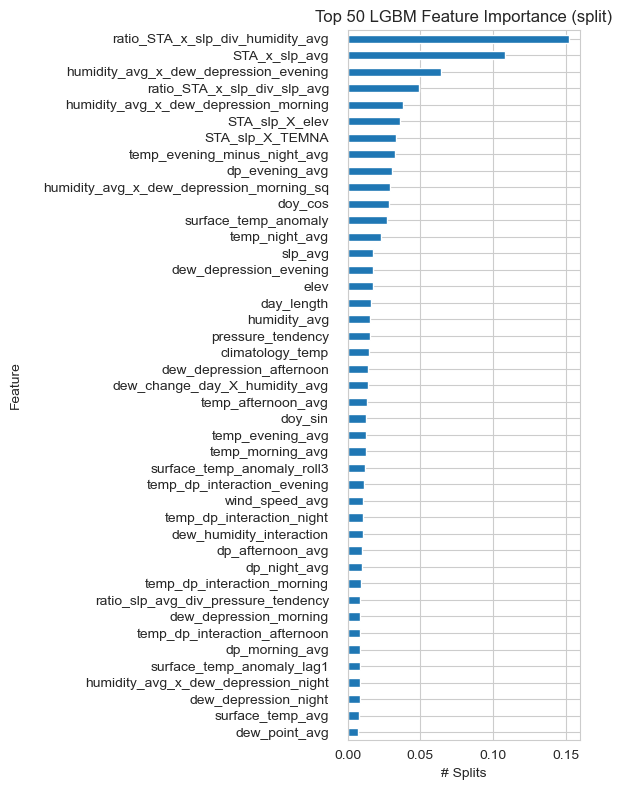

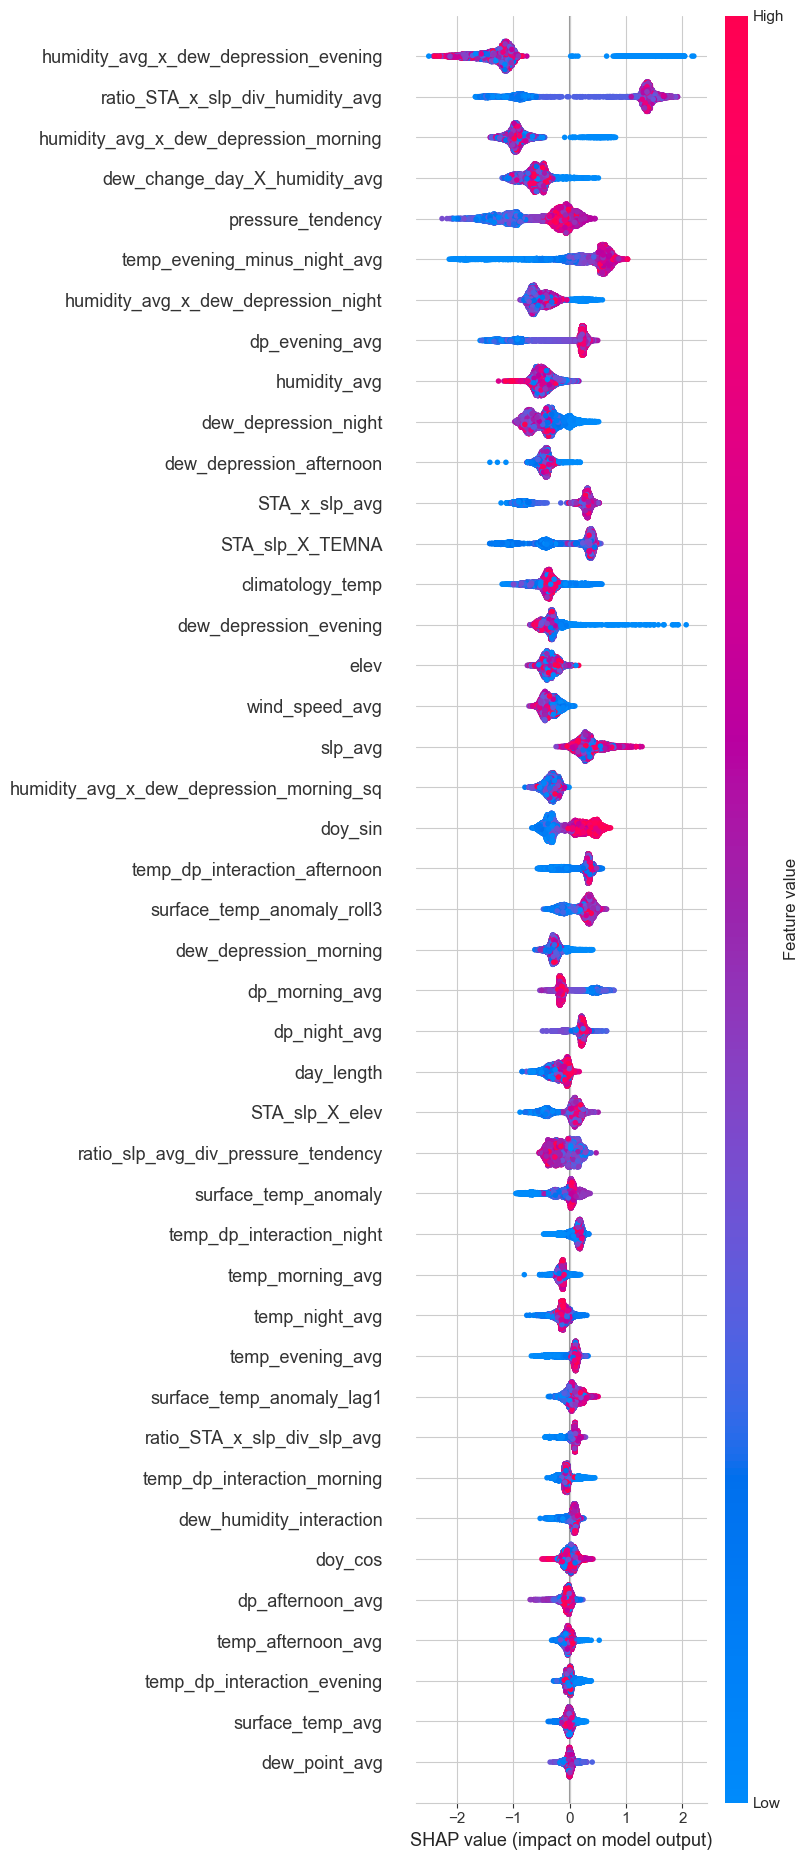

In [181]:
imp_split = xgb_model.feature_importances_

feat_imp_split = pd.Series(imp_split, index=features).sort_values(ascending=False)

top_N = 50

# 1) Plot split importances
fig, ax = plt.subplots(figsize=(6, 8))
feat_imp_split.head(top_N).plot(kind='barh', ax=ax)
ax.invert_yaxis()
ax.set_title(f'Top {top_N} LGBM Feature Importance (split)')
ax.set_xlabel('# Splits')
ax.set_ylabel('Feature', labelpad=15)
ax.tick_params(axis='y', pad=10)
plt.subplots_adjust(left=0.3)
plt.tight_layout()
plt.show()

# 2) SHAP Summary Plots
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, max_display=top_N, feature_names=features)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feat_shap_imp = pd.Series(mean_abs_shap, index=features).sort_values(ascending=False)

In [182]:
print(f"Top {top_N} XGB Importances (split):")
print(feat_imp_split.head(top_N).to_string())
print("="*50)
print("Top SHAP Feature Importances (mean |SHAP value|):")
print(feat_shap_imp.head(top_N).to_string())

Top 50 XGB Importances (split):
ratio_STA_x_slp_div_humidity_avg            0.152102
STA_x_slp_avg                               0.108057
humidity_avg_x_dew_depression_evening       0.064413
ratio_STA_x_slp_div_slp_avg                 0.048711
humidity_avg_x_dew_depression_morning       0.037858
STA_slp_X_elev                              0.035673
STA_slp_X_TEMNA                             0.033290
temp_evening_minus_night_avg                0.032260
dp_evening_avg                              0.030341
humidity_avg_x_dew_depression_morning_sq    0.029070
doy_cos                                     0.028067
surface_temp_anomaly                        0.027309
temp_night_avg                              0.022956
slp_avg                                     0.017396
dew_depression_evening                      0.017239
elev                                        0.017176
day_length                                  0.015845
humidity_avg                                0.015363
pressure_tende

# Feature Selection with SHAP

In [183]:
print("Lowest SHAP Importances:")
print(feat_shap_imp.tail(50).to_string())

Lowest SHAP Importances:
humidity_avg_x_dew_depression_evening       1.313731
ratio_STA_x_slp_div_humidity_avg            1.296478
humidity_avg_x_dew_depression_morning       0.935409
dew_change_day_X_humidity_avg               0.613061
pressure_tendency                           0.528823
temp_evening_minus_night_avg                0.527797
humidity_avg_x_dew_depression_night         0.502226
dp_evening_avg                              0.470836
humidity_avg                                0.465255
dew_depression_night                        0.440933
dew_depression_afternoon                    0.436139
STA_x_slp_avg                               0.430942
STA_slp_X_TEMNA                             0.430230
climatology_temp                            0.403669
dew_depression_evening                      0.345140
elev                                        0.342281
wind_speed_avg                              0.340916
slp_avg                                     0.331450
humidity_avg_x_dew_de

# Predict with Test Dataset

In [184]:
# y_test_pred = xgb_model.predict(X_test_scaled)
#
# submission = pd.DataFrame({
#     "id": test_df_final["id"],
#     "target": y_test_pred
# })
#
# now = datetime.now().strftime("%Y%m%d_%H%M%S")
#
# submission.to_csv(f'./output/submission_{now}.csv', index=False)